Environment: pytorch

# <font color = 'purple'>Data Exploration
[Dataset documentation](https://www.cs.toronto.edu/~kriz/cifar.html)   
In this notebook, we explore the CIFAR-10 dataset, and identify mean and standard-deviation for each channel (R, G, B), to facilitate image normalisation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## <font color = 'blue'>Load training & test datasets
- format as dataloader for memory-efficient handling

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset.data.shape

(50000, 32, 32, 3)

In [5]:
testset.data.shape

(10000, 32, 32, 3)

- Training set has 50,000 images; test set has 10,000 images
- Each image is 32px x 32px, and has 3 channels: RGB

In [6]:
testset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
my_classes = testset.classes
my_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

10 classes as listed above

Text(0.5, 1.0, 'test set')

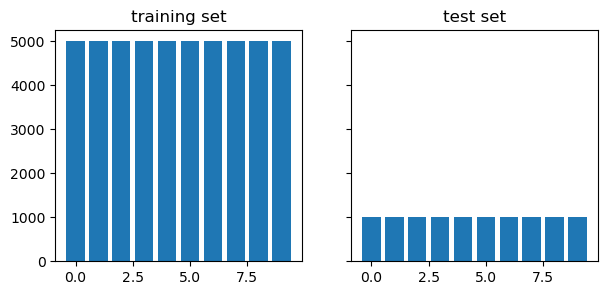

In [8]:
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(7,3), sharey=True)
ax1.hist(trainset.targets, bins=np.arange(0,11)-0.5, rwidth=0.8)
ax1.set_title('training set')
ax2.hist(testset.targets, bins=np.arange(0,11)-0.5, rwidth=0.8)
ax2.set_title('test set')

Even distribution of classes in both training and test sets

## <font color = 'blue'>Show a few random images

In [9]:
def imshow(img, myax):
    """
    Displays requested image
    :param img: tensor object
    :param myax: axis to plot on 
    """
    npimg = img.numpy()  # convert tensor to numpy array. Shape is (3 channels x 32 px x 32 px)
    myax.imshow(np.transpose(npimg, (1, 2, 0)))  # reshape np array to (32 px x 32 px x 3 ch) and display image. Note imshow requires array shape (MxNx3 for RGB image)


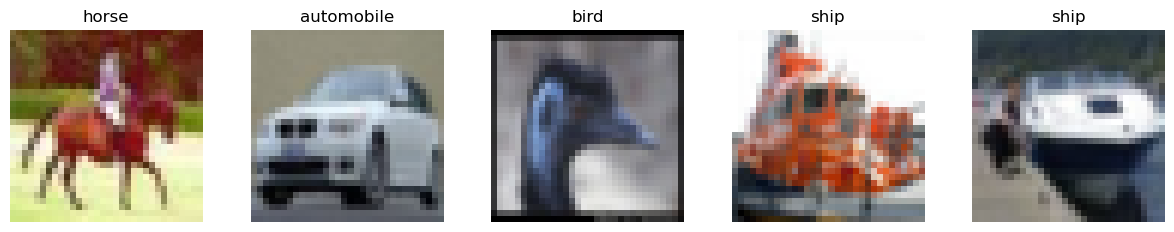

In [10]:
train_iter = iter(trainloader)
images, labels = next(train_iter) # returns 5 random training images and their labels

fig, ax = plt.subplots(figsize=(15,2.5), ncols=5)
ax = ax.flatten()
for i in range(len(images)):
    imshow(images[i], myax=ax[i])
    ax[i].axis('off')
    ax[i].set_title(my_classes[labels[i].item()])

## <font color = 'blue'>Normalise images

**Get mean & std dev for each channel**

In [11]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [12]:
get_mean_and_std(trainloader)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [13]:
get_mean_and_std(testloader)

(tensor([0.4942, 0.4851, 0.4504]), tensor([0.2467, 0.2429, 0.2616]))

- Note that mean and std dev are very similar for train and test sets. Sufficient to use training set.
- values are also similar to ImageNet values: mean = [0.485, 0.456, 0.406] ; std = [0.229, 0.224, 0.225]

In [14]:
mean, std = get_mean_and_std(trainloader)

**Normalise data**

In [15]:
my_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

In [16]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = my_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = my_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


**Check new mean & std dev**

In [17]:
get_mean_and_std(trainloader)

(tensor([-3.6911e-06,  1.0894e-06, -1.4311e-06]),
 tensor([1.0000, 1.0000, 1.0000]))

In [18]:
get_mean_and_std(testloader)

(tensor([0.0114, 0.0122, 0.0148]), tensor([0.9985, 0.9976, 1.0000]))

**Save mean & std dev to use for future transformations**

In [19]:
mean , std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [20]:
torch.save(mean, 'mean.pt')
torch.save(std, 'std_dev.pt')